In [5]:
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.manifold import TSNE
import os, re, glob2, pickle

from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
# custom paramers: change these parameters to properly run on your machine
image_path = '/home/esoroush/Datasets/MSRC/MSRC/' # addres of images
no_of_images = 1600 # number of images. It is recommended to use a square of 2 number
ellipside =False # elipsoid or rectangular visualization
image_width = 64 # width and height of each visualized images
# choices are: inception, raw and vggfaces
feature_extraction = 'inception' # feature extraction method

In [24]:
# find all images
image_names  = glob2.glob(image_path + "**/*.png") 
image_names +=glob2.glob(image_path + "**/*.jpg")
image_names +=glob2.glob(image_path + "**/*.gif")
# suffle images
np.random.seed(3)
np.random.shuffle(image_names)
if no_of_images > len(image_names):
    no_of_images = len(image_names)
image_names = image_names[:no_of_images]

In [25]:
# Google inception pre-trained network
if feature_extraction == 'inception':
    print('using %s network/method for feature extraction'%feature_extraction)
    import sys, tarfile
    from six.moves import urllib
    model_dir = os.path.join(os.environ['HOME'], '.tensorflow/models')
    DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
    def create_graph():

        """Creates a graph from saved GraphDef file and returns a saver."""
        # Creates graph from saved graph_def.pb.
        with tf.gfile.FastGFile(os.path.join(
          model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name='')

    def run_inference_on_image(image):

        """Runs forward path on an image.
        Args:
        image: Image file name.

        Returns:
        off the shelf 2048 feature vector
        """
        if not tf.gfile.Exists(image):
            tf.logging.fatal('File does not exist %s', image)
        image_data = tf.gfile.FastGFile(image, 'rb').read()


        with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
            pool3 = sess.graph.get_tensor_by_name('pool_3:0')
            features = sess.run(pool3,
                                   {'DecodeJpeg/contents:0': image_data})
            return features
    
    def maybe_download_and_extract():
        """Download and extract model tar file."""
        dest_directory = model_dir
        if not os.path.exists(dest_directory):
            os.makedirs(dest_directory)
        filename = DATA_URL.split('/')[-1]
        filepath = os.path.join(dest_directory, filename)
        if not os.path.exists(filepath):
            def _progress(count, block_size, total_size):
                sys.stdout.write('\r>> Downloading %s %.1f%%' % ( 
                      filename, float(count * block_size) / float(total_size) * 100.0))
                sys.stdout.flush()
            filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
            print()
            statinfo = os.stat(filepath)
            print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)


    maybe_download_and_extract()
    # Creates graph from saved GraphDef.
    create_graph()
    feature_filename = '%s-feature-inception-%d.p'%(image_path.split('/')[-2], no_of_images)
    if os.path.exists(feature_filename):
        with open(feature_filename, 'rb') as f:
            features, image_names = pickle.load(f)
    else:
        features = np.zeros([no_of_images, 2048])
        for i in xrange(no_of_images):
            print('image name: %s index: %d/%d' %(image_names[i], i, no_of_images))
            features[i, :] = run_inference_on_image(image=image_names[i]).squeeze()
        with open(feature_filename, 'wb') as f:
            pickle.dump((features, image_names), f)

using inception network/method for feature extraction


In [26]:
# raw image pixels resized to 100x100
if feature_extraction == 'raw':
    print('using %s network/method for feature extraction'%feature_extraction)
    features = np.zeros([no_of_images, 100*100])
    for i, name in enumerate(image_names):
        features[i, :] = np.asarray(Image.open(name).resize((100, 100)).convert('L')).reshape(-1,)

In [27]:
# vgg face pretrained network
if feature_extraction == 'vggfaces':
    print('using %s network/method for feature extraction'%feature_extraction)
    # Convolution Features
    features = np.zeros([no_of_images, 2048])
    vgg_model_conv = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
    # FC7 Features
    vgg_model = VGGFace() # pooling: None, avg or max
    out = vgg_model.get_layer('fc7').output
    vgg_model_fc7 = Model(vgg_model.input, out)

    feature_filename = '%s-feature-vggfaces-%d.p'%(image_path.split('/')[-2], no_of_images)
    if os.path.exists(feature_filename):
        with open(feature_filename, 'rb') as f:
            features, image_names = pickle.load(f)
    else:
        features = np.zeros([no_of_images, 4096])
        for i, name in enumerate(image_names):
            img = image.load_img(name, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = utils.preprocess_input(x)
            print('image name: %s progress: %d/%d'%(name, i, no_of_images))
            features[i, :] = vgg_model_fc7.predict(x)
        with open(feature_filename, 'wb') as f:
            pickle.dump((features, image_names), f)

In [28]:
# use tsne to cluster images in 2 dimensions
tsne = TSNE()
reduced = tsne.fit_transform(features)
reduced_transformed = reduced - np.min(reduced, axis=0)
reduced_transformed /= np.max(reduced_transformed, axis=0)
image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

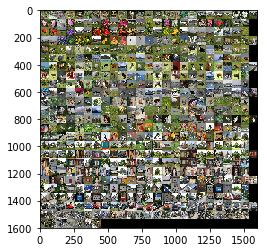

In [39]:
# draw all images in a merged image
merged_width = int(np.ceil(np.sqrt(no_of_images))*image_width)
merged_image = np.zeros((merged_width, merged_width, 3), dtype='uint8')

for counter, index in enumerate(image_xindex_sorted):
    # set location
    if ellipside:
        a = np.ceil(reduced_transformed[counter, 0] * (merged_width-image_width-1)+1)
        b = np.ceil(reduced_transformed[counter, 1] * (merged_width-image_width-1)+1)
        a = int(a - np.mod(a-1,image_width) + 1)
        b = int(b - np.mod(b-1,image_width) + 1)
        if merged_image[a,b,0] != 0:
            continue
        image_address = image_names[counter]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a:a+image_width, b:b+image_width,:] = img[:,:,:3]
    else:
        b = int(np.mod(counter, np.sqrt(no_of_images)))
        a = int(np.mod(counter//np.sqrt(no_of_images), np.sqrt(no_of_images)))
        image_address = image_names[index]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a*image_width:(a+1)*image_width, b*image_width:(b+1)*image_width,:] = img[:,:,:3]

plt.imshow(merged_image)
plt.show()
merged_image = Image.fromarray(merged_image)
if ellipside:
    merged_image.save('merged-%s-ellipsoide-inception.png'%image_path.split('/')[-2])
else:
    merged_image.save('merged-%s.png'%image_path.split('/')[-2])


In [37]:
print b*image_width, (b+1)*image_width

1536 1600


In [38]:
print b

24
